# Libraries to use

In [ ]:
import pandas as pd
import numpy as np

from sklearn import metrics
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import gc
import time

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

import re

Mounted at /content/drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
pip install pymorphy2

In [ ]:
pip install nltk

In [ ]:
pip install pytorch-transformers

# Data uploading

In [ ]:
cups_train = pd.read_csv('https://raw.githubusercontent.com/OlgaChaganova/TOXIC-/main/train.txt', sep='\t', names=['label', 'message'], index_col=0)

for label in np.unique(cups_train['label']):
  if label != "__label__NORMAL":
    cups_train['label'].replace(label, True, inplace=True)
  else:
    cups_train['label'].replace(label, False, inplace=True)

cups_train['split'] = 'train'
cups_train = cups_train.loc[:, ['message', 'label', 'split']]

cups_train.head()

,message,label,split
41127,дворника надо тоже уничтожить!,True,train
6812,"моя старшая неделю шипела, не принимала подкид...",False,train
6256,полностью с вами согласна!,False,train
189636,"хоть ногу вверх, ничего не изменится",False,train
99053,а что значит - левого ребенка?,False,train


In [ ]:
sum(cups_train['label'] == False), sum(cups_train['label'] == True)

(122194, 26581)

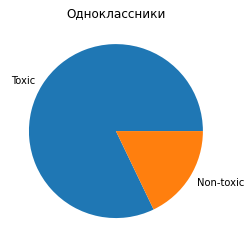

In [ ]:
categories = ['Toxic', 'Non-toxic']
values = [sum(cups_train['label'] == False), sum(cups_train['label'] == True)]
plt.title('Одноклассники')
plt.pie(x=values, labels=categories)

None

In [ ]:
tinkoff_data = pd.read_csv('https://raw.githubusercontent.com/OlgaChaganova/TOXIC-/main/pulse_stage1_patch.csv')

In [ ]:
sum(tinkoff_data['label'] == False), sum(tinkoff_data['label'] == True)

(33466, 1141)

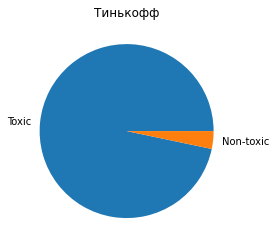

In [ ]:
categories = ['Toxic', 'Non-toxic']
values = [sum(tinkoff_data['label'] == False), sum(tinkoff_data['label'] == True)]
plt.title('Тинькофф')
plt.pie(x=values, labels=categories)

None

In [ ]:
kaggle_data = pd.read_csv('https://raw.githubusercontent.com/OlgaChaganova/TOXIC-/main/russian%20toxic%20comments%20(kaggle).csv',
                          names=['message', 'label'], header=0)
kaggle_data['split'] = 'train'
kaggle_data['label'] = kaggle_data['label'].astype(bool)
kaggle_data.head()

,message,label,split
0,"Верблюдов-то за что? Дебилы, бл...\n",True,train
1,"Хохлы, это отдушина затюканого россиянина, мол...",True,train
2,Собаке - собачья смерть\n,True,train
3,"Страницу обнови, дебил. Это тоже не оскорблени...",True,train
4,"тебя не убедил 6-страничный пдф в том, что Скр...",True,train


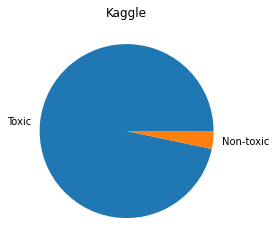

In [ ]:
categories = ['Toxic', 'Non-toxic']
values = [sum(tinkoff_data['label'] == False), sum(tinkoff_data['label'] == True)]
plt.title('Kaggle')
plt.pie(x=values, labels=categories)

None

In [ ]:
sum(kaggle_data['label'] == False), sum(kaggle_data['label'] == True)

(9586, 4826)

In [ ]:
DATA = pd.concat([tinkoff_data, cups_train[cups_train['label'] == True], kaggle_data], axis=0).reset_index(drop=True)
DATA

,message,label,split
0,Пиздабол ещё тот,True,train
1,"Заколебали кукарекать, скоро весь пульс будет ...",True,train
2,На деле собака сутулая,True,train
3,Пшнх от сюда тварь,True,train
4,"плати за мое молчание клоп , сутки молчу 200 б...",True,train
...,...,...,...
75595,Вонючий совковый скот прибежал и ноет. А вот и...,True,train
75596,А кого любить? Гоблина тупорылого что-ли? Или ...,True,train
75597,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",False,train
75598,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,True,train


In [ ]:
DATA[DATA['split'] == 'train']['label'].value_counts()


False    36374
True     32320
Name: label, dtype: int64

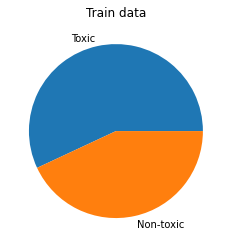

In [ ]:
categories = ['Toxic', 'Non-toxic']
values = [sum(DATA['label'] == False), sum(DATA['label'] == True)]
plt.title('Train data')
plt.pie(x=values, labels=categories)

None

In [ ]:
data_train = DATA[DATA['split'] == 'train'].copy()
data_valid = DATA[DATA['split'] == 'valid'].copy()

del data_train['split'], data_valid['split']

# Text Cleaning 

In [ ]:
emoji_pattern = re.compile("["
                       u"\U0001F600-\U0001F64F"  # emoticons
                       u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                       u"\U0001F680-\U0001F6FF"  # transport & map symbols
                       u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       u"\U00002702-\U000027B0"
                       u"\U000024C2-\U0001F251"
                       "]+", flags=re.UNICODE)  

stop= stopwords.words("russian")

def remove_emoji(string):
    return emoji_pattern.sub(r'', string)

def prepross_text_in_dataset(dataset):
  dataset["message"] = dataset["message"].str.lower() #к нижнему регистру

  dataset["message"] = dataset["message"].str.replace('[^\w\s]',' ') #убираем пунктуацию

  dataset["message"] = dataset["message"].str.replace(' \d+',' ') #убираем цифры

  dataset["message"] = dataset["message"].str.replace('\n', ' ') #убираем новые строки

  dataset['message'] = dataset['message'].apply(remove_emoji) #убираем emoji

  #удаляем стоп-слова
  pat = r'\b(?:{})\b'.format('|'.join(stop))
  dataset['message_sw'] = dataset['message'].str.replace(pat, '')
  dataset['message_sw'] = dataset['message_sw'].str.replace(r'\s+', ' ')

  del dataset['message']
  dataset.rename(columns={'message_sw' : 'message'}, inplace=True) 

  dataset['message'] = dataset['message'].str.findall('\w{3,}').str.join(' ') # удаляем слова короче 3 символов

  return dataset.loc[:, ['message', 'label']]

# Task 1: toxic comments detection

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from pytorch_transformers import BertTokenizer, BertConfig

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device == torch.device('cpu'):
    print('Using cpu')
else:
    n_gpu = torch.cuda.device_count()
    print('Using {} GPUs'.format(torch.cuda.get_device_name(0)))

Using Tesla K80 GPUs


In [ ]:
def prepare_data_for_bert(data, MAX_LEN, BATCH_SIZE):
  data = prepross_text_in_dataset(data) # препоцессим

  comments = ["[CLS] " + message + " [SEP]" for message in data.message]
  labels = data.label
  labels = np.where(labels == True, 1, 0)

  assert len(comments) == len(labels)

  tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

  tokenized_texts = [tokenizer.tokenize(comment) for comment in comments]

  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts] # !!!!
  input_ids = pad_sequences(
      input_ids,
      maxlen=MAX_LEN,
      dtype="long",
      truncating="post",
      padding="post"
  )
  attention_masks = [[float(i>0) for i in seq] for seq in input_ids]


  inputs = torch.tensor(input_ids)
  labels = torch.tensor(labels).reshape(len(data),1)
  masks = torch.tensor(attention_masks)


  data_tensor = TensorDataset(inputs, masks, labels)
  dataloader = DataLoader(
      data_tensor,
      sampler=RandomSampler(data_tensor),
      batch_size=BATCH_SIZE
  )

  return dataloader

## Data preprocessing и fine-tuning BERT

In [ ]:
message_count_train = data_train['message'].str.len()
message_count_valid = data_valid['message'].str.len()

In [ ]:
message_count_train.describe()

count    68694.000000
mean       109.458977
std        152.107650
min          3.000000
25%         34.000000
50%         69.000000
75%        134.000000
max       7349.000000
Name: message, dtype: float64

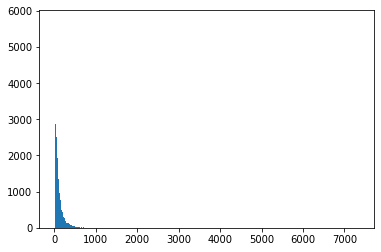

In [ ]:
plt.hist(message_count_train[message_count_train < 500], bins='auto')
None

In [ ]:
train_dataloader = prepare_data_for_bert(data_train, 200, 16)

In [ ]:
validation_dataloader = prepare_data_for_bert(data_valid, 200, 16)

## Model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

100%|██████████| 440473133/440473133 [00:34<00:00, 12856276.13B/s]


In [ ]:
gc.collect()
torch.cuda.empty_cache()

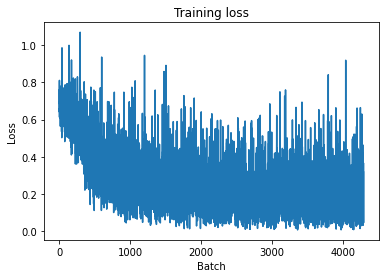

Loss на обучающей выборке: 0.26632


In [ ]:
from IPython.display import clear_output

train_loss_set = []
train_loss = 0

NUM_EPOCHS = 1

# Обучение
# Переводим модель в training mode
model.train()

for i in range(NUM_EPOCHS):

  for step, batch in enumerate(train_dataloader):
      # добавляем батч для вычисления на GPU
      batch = tuple(t.to(device) for t in batch)
      # Распаковываем данные из dataloader
      b_input_ids, b_input_mask, b_labels = batch
      
      # если не сделать .zero_grad(), градиенты будут накапливаться
      optimizer.zero_grad()
      
      # Forward pass
      loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

      train_loss_set.append(loss[0].item())  
      
      # Backward pass
      loss[0].backward()
      
      # Обновляем параметры и делаем шаг используя посчитанные градиенты
      optimizer.step()

      # Обновляем loss
      train_loss += loss[0].item()
      
      # Рисуем график
      clear_output(True)
      plt.plot(train_loss_set)
      plt.title("Training loss")
      plt.xlabel("Batch")
      plt.ylabel("Loss")
      plt.show()
    
print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))


In [ ]:
# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

In [ ]:
print("F1 = ", f1_score(valid_labels, valid_preds))
print("Recall = ", recall_score(valid_labels, valid_preds))
print("Precision = ", precision_score(valid_labels, valid_preds))

In [ ]:
ConfMatrix = confusion_matrix(valid_labels, valid_preds)
fig = plt.figure()
ax = plt.subplot()
sns.heatmap(ConfMatrix, annot=True, cbar=False, cmap='twilight', linewidth=0.5, fmt="d")
plt.title('Confusion Matrix')

plt.xlabel('True')
plt.ylabel('Predicted')
ax.xaxis.set_ticklabels(['Non-toxic', 'Toxic'])
ax.yaxis.set_ticklabels(['Non-toxic', 'Toxic'])
plt.show()

## Saving trained model

In [ ]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, '/content/drive/MyDrive/bert_fine_tuned') # BERT из dls (параметры не меняли)

# **PREDICTING (ON TEST DATASET)**

In [ ]:
data_test = pd.read_csv('https://raw.githubusercontent.com/OlgaChaganova/TOXIC-/main/test.csv', 
                        names = ['message'], header=0)

data_test['label'] = False

data_test_message = data_test.copy()
data_test_message

,message,label
0,"А я и не выступаю, он мне тоже не особо симпат...",False
1,"Хочешь расскажу, как заинтриговать человека-за...",False
2,Инвестинг.com,False
3,"Ересь,смотрите хотя бы канал ""Силиконовая долина""",False
4,"меня тинькоф кинул с плечами, самый дорогой ур...",False
...,...,...
6165,Нах?,False
6166,да уже слышали таких скептиков. С 2008 года пр...,False
6167,Что такое шорт?,False
6168,"но никто не запрещал фотки выкидывать, не нрав...",False


In [ ]:
test_dataloader = prepare_data_for_bert(data_test, 150, 32)

test_preds, test_labels = [], []

for batch in test_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (563 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
data_answer = data_test.copy()
data_answer['toxic'] = test_preds
data_answer['message'] = data_test_message['message']
data_answer

,label,message,toxic
0,False,"А я и не выступаю, он мне тоже не особо симпат...",0
1,False,"Хочешь расскажу, как заинтриговать человека-за...",0
2,False,Инвестинг.com,0
3,False,"Ересь,смотрите хотя бы канал ""Силиконовая долина""",0
4,False,"меня тинькоф кинул с плечами, самый дорогой ур...",0
...,...,...,...
6165,False,Нах?,1
6166,False,да уже слышали таких скептиков. С 2008 года пр...,0
6167,False,Что такое шорт?,0
6168,False,"но никто не запрещал фотки выкидывать, не нрав...",0


In [ ]:
del data_answer['label']
data_answer = data_answer.rename(columns={'message' : 'text'})
data_answer

,text,toxic
0,"А я и не выступаю, он мне тоже не особо симпат...",0
1,"Хочешь расскажу, как заинтриговать человека-за...",0
2,Инвестинг.com,0
3,"Ересь,смотрите хотя бы канал ""Силиконовая долина""",0
4,"меня тинькоф кинул с плечами, самый дорогой ур...",0
...,...,...
6165,Нах?,1
6166,да уже слышали таких скептиков. С 2008 года пр...,0
6167,Что такое шорт?,0
6168,"но никто не запрещал фотки выкидывать, не нрав...",0


In [ ]:
data_answer.to_csv('data_answer_TOXIC2.csv', index=False)

# Task 2: fighting against unintended bias

## Re-marked data

In [ ]:
data2 = pd.read_csv('https://raw.githubusercontent.com/OlgaChaganova/TOXIC-/main/categories.csv')

In [ ]:
def calculate_metrics_on_test(data, model):

  SUBGROUP_AUC = 'subgroup_auc'
  BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
  BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

  data_cleaned = prepross_text_in_dataset2(data)
  validation_dataloader = prepare_data_for_bert(data_cleaned.loc[:, ['message', 'label']], 150, 32)
  
  model.eval()

  valid_preds, valid_labels, valid_proba = [], [], []

  for batch in validation_dataloader:   
      # добавляем батч для вычисления на GPU
      batch = tuple(t.to(device) for t in batch)
      
      # Распаковываем данные из dataloader
      b_input_ids, b_input_mask, b_labels = batch
      
      # При использовании .no_grad() модель не будет считать и хранить градиенты.
      # Это ускорит процесс предсказания меток для валидационных данных.
      with torch.no_grad():
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

      # Перемещаем logits и метки классов на CPU для дальнейшей работы
      logits = logits[0].detach().cpu().numpy()
      p = torch.nn.functional.softmax(torch.from_numpy(logits), dim=1)

      max_p = []
      for i in range(len(p)):
        max_p.append(torch.max(p[i]))

      label_ids = b_labels.to('cpu').numpy()
      
      batch_preds = np.argmax(logits, axis=1)
      batch_labels = np.concatenate(label_ids)
      
      valid_proba.extend(max_p)
      valid_preds.extend(batch_preds)
      valid_labels.extend(batch_labels)

  data_cleaned['pred_proba'] = valid_proba # p

  model_preds = 'pred_proba'
  target_label = 'label'

  categories = data_cleaned.category.unique()
  for category in categories:
      data_cleaned[category] = data_cleaned.category == category

  bias_metrics_df = compute_bias_metrics_for_model(data_cleaned, categories, model_preds, target_label)

  return bias_metrics_df.dropna()

In [ ]:
def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
  
  
  SUBGROUP_AUC = 'subgroup_auc'
  BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
  BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

  """Computes per-subgroup metrics for all subgroups and one model."""
  records = []
  for subgroup in subgroups:
      record = {
          'subgroup': subgroup,
          'subgroup_size': len(dataset[dataset[subgroup]])
      }
      record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
      record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
      record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
      records.append(record)
      
  return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)


def calculate_overall_auc(df, model_name):
    true_labels = df['label']
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df['subgroup_auc'], POWER),
        power_mean(bias_df['bpsn_auc'], POWER),
        power_mean(bias_df['bnsp_auc'], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

In [ ]:
bias_metrics_df = calculate_metrics_on_test(data2, model)
bias_metrics_df


overall_auc = calculate_overall_auc(data2, 'pred_proba')
get_final_metric(bias_metrics_df, overall_auc)

0.4869334526969905

In [ ]:
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
3,другое,937,0.445995,0.502644,0.453659
2,политика,995,0.464932,0.469317,0.487182
0,сексизм,825,0.492248,0.473121,0.494653
1,компании,1018,0.650879,0.489917,0.624245


## Data by Tinkoff (original)

In [ ]:
data3 = pd.read_csv('https://raw.githubusercontent.com/OlgaChaganova/TOXIC-/main/task2_data.csv')


In [ ]:
bias_metrics_df = calculate_metrics_on_test(data3, model)

overall_auc = calculate_overall_auc(data3, 'pred_proba')
get_final_metric(bias_metrics_df, overall_auc)

0.5062368529973822

In [ ]:
bias_metrics_df

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc
3,политика,986,0.453345,0.518760,0.452401
0,сексизм,820,0.496415,0.523503,0.488172
4,другое,969,0.520185,0.489469,0.531196
1,компании,1000,0.601637,0.511169,0.594315
